## Metric Analisys Case Study - Sberbank

Housing costs demand a significant investment from both consumers and developers. And when it comes to planning a budget—whether personal or corporate—the last thing anyone needs is uncertainty about one of their biggets expenses. Sberbank, Russia’s oldest and largest bank, helps their customers by making predictions about realty prices so renters, developers, and lenders are more confident when they sign a lease or purchase a building.

Although the housing market is relatively stable in Russia, the country’s volatile economy makes forecasting prices as a function of apartment characteristics a unique challenge. Complex interactions between housing features such as number of bedrooms and location are enough to make pricing predictions complicated. Adding an unstable economy to the mix means Sberbank and their customers need more than simple regression models in their arsenal.

In this competition, Sberbank is challenging Kagglers to develop algorithms which use a broad spectrum of features to predict realty prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

Source: https://www.kaggle.com/c/sberbank-russian-housing-market/overview

Scripts used:
1. https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank
2. https://www.kaggle.com/aharless/latest-iteration-in-this-silly-game
    

### 1. Imports

In [1]:
import os
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns
#import xgboost             as xgboost
import xgboost             as xgb
from sklearn               import model_selection, preprocessing
from sklearn.linear_model  import LinearRegression
from pandas_profiling      import ProfileReport
from xgboost               import XGBClassifier



os.environ['KMP_DUPLICATE_LIB_OK']='True'
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

### 1.1 Data Imports

In [54]:
# Load data.
df_train = pd.read_csv('input/train.csv', index_col='id', parse_dates=[1], 
                    true_values=['yes'], false_values=['no'])
df_test = pd.read_csv('input/test.csv', index_col='id', parse_dates=[1], 
                   true_values=['yes'], false_values=['no'])
print(df_train.shape)
print(df_test.shape)

(30471, 291)
(7662, 290)


In [ ]:
df_test = pd.read_csv("input/train.csv")
df_test.shape

In [3]:
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [4]:
# profile = ProfileReport(df_train, minimal=True)
# profile

####FAIL

In [5]:
df_train.isna().sum().sort_values(ascending = False)

hospital_beds_raion           14441
build_year                    13605
state                         13559
cafe_avg_price_500            13281
cafe_sum_500_max_price_avg    13281
                              ...  
office_count_1000                 0
prom_part_1000                    0
green_part_1000                   0
market_count_500                  0
id                                0
Length: 292, dtype: int64

### 2. Data Exploration

There are quite a few variables in this dataset. 

Let us start with target variable exploration - 'price_doc'. First let us do a scatter plot to see if there are any outliers in the data.

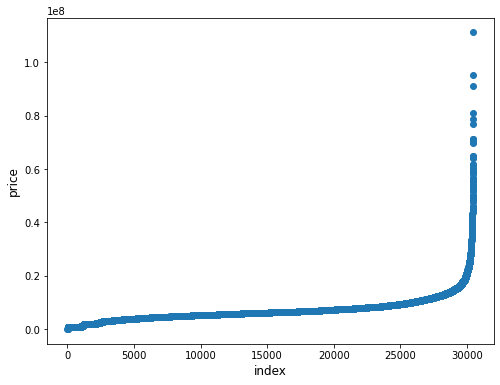

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(range(df_train.shape[0]), np.sort(df_train.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

Looks okay to me. Also since the metric is RMSLE, I think it is okay to have it as such. However if needed, one can truncate the high values. 

We can now bin the 'price_doc' and plot it.

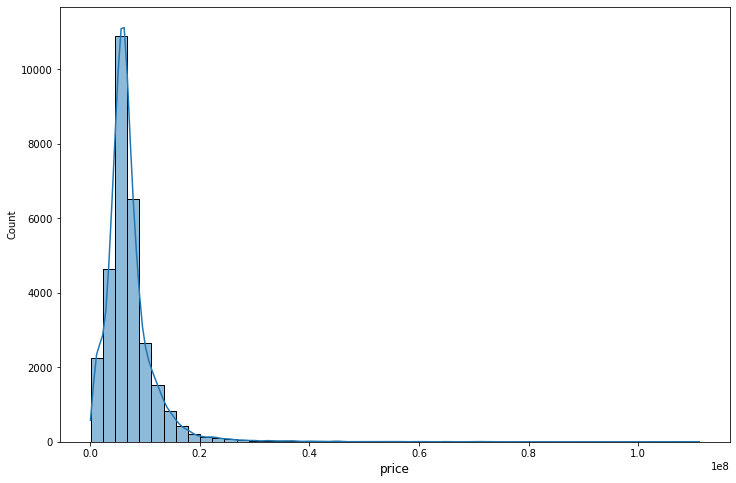

In [7]:
plt.figure(figsize=(12,8))
sns.histplot(df_train.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [8]:
### Flávio

Certainly a very long right tail. Since our metric is Root Mean Square **Logarithmic** error, let us plot the log of price_doc variable.

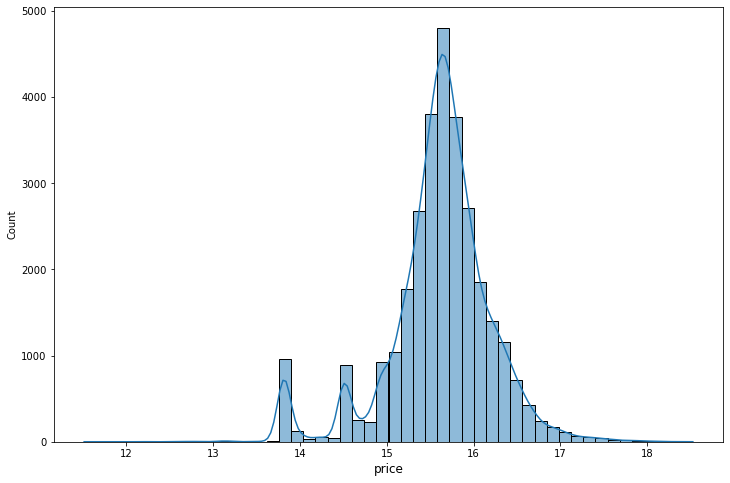

In [9]:
plt.figure(figsize=(12,8))
sns.histplot(np.log(df_train.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

This looks much better than the previous one. 

Now let us see how the median housing price change with time. 

In [10]:
df_train['yearmonth'] = df_train['timestamp'].apply(lambda x: x[:4]+x[5:7])
df_grouped = df_train.groupby('yearmonth')['price_doc'].aggregate(np.mean).reset_index()

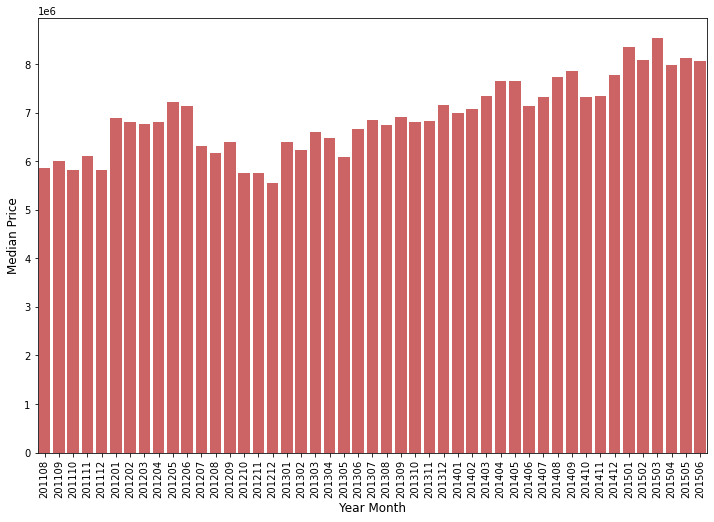

In [11]:
plt.figure(figsize=(12,8))
sns.barplot(data = df_grouped, x='yearmonth', y='price_doc', alpha=0.8, color=color[3])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [12]:
df_train['yearmonth'] = df_train['timestamp'].apply(lambda x: x[:4]+x[5:7])
df_grouped = df_train.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

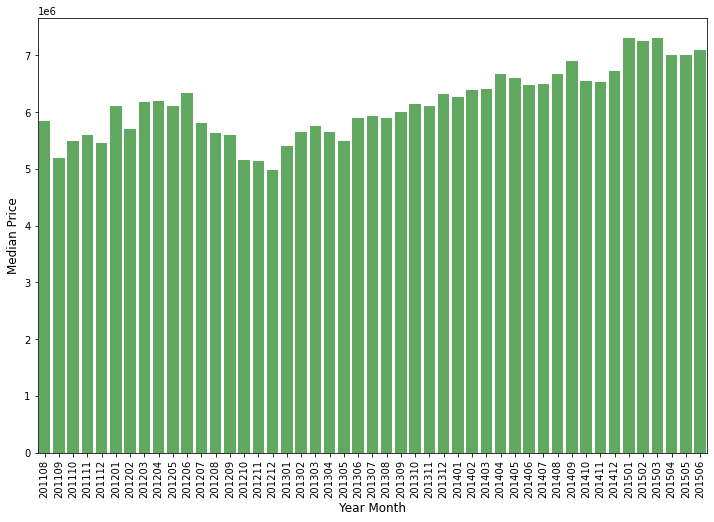

In [13]:
plt.figure(figsize=(12,8))
sns.barplot(data = df_grouped, x='yearmonth', y='price_doc', alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

There are some variations in the median price with respect to time. Towards the end, there seems to be some linear increase in the price values.

Now let us dive into other variables and see. Let us first start with getting the count of different data types. 

In [41]:
train_df = pd.read_csv("input/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv('input/test.csv', parse_dates=['timestamp'])
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()
id_test = test_df.id

So majority of them are numerical variables with 15 factor variables and 1 date variable.

Let us explore the number of missing values in each column.

### Missing Values

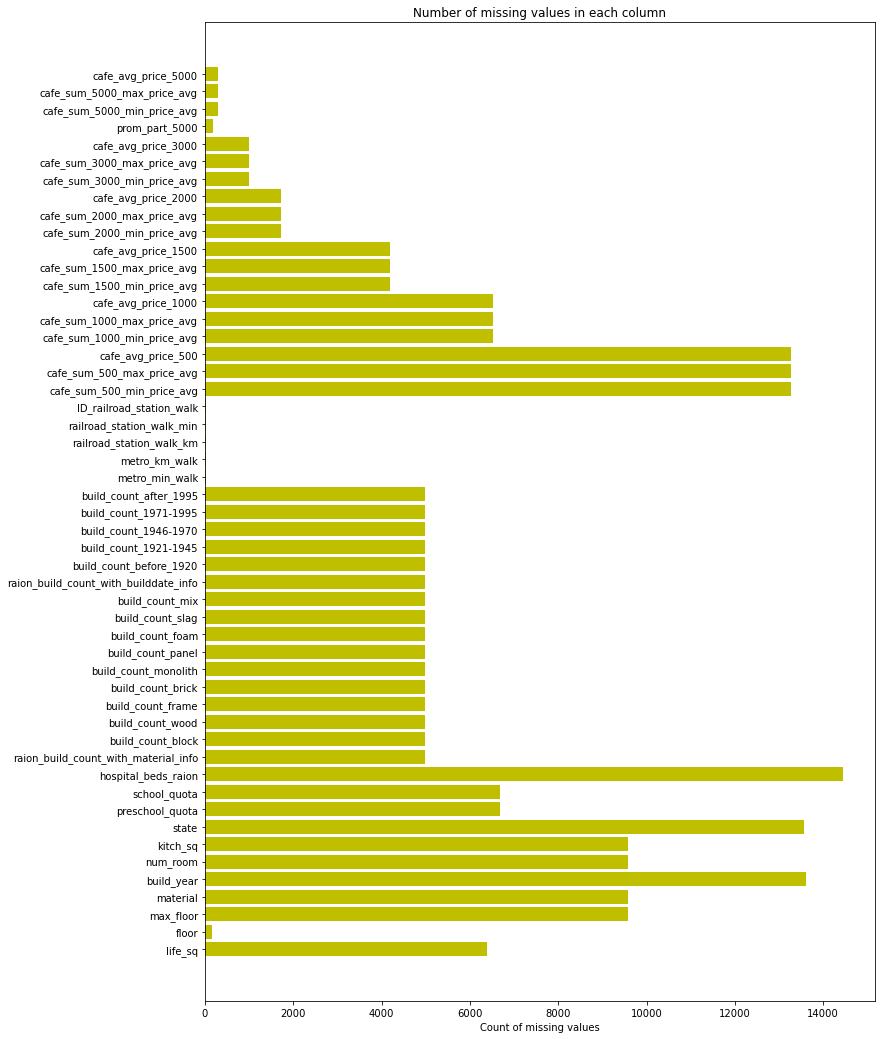

In [42]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Seems variables are found to missing as groups.

Since there are 292 variables, let us build a basic xgboost model and then explore only the important variables.

In [16]:
# for f in train_df.columns:
#     if train_df[f].dtype=='object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(train_df[f].values)) 
#         train_df[f] = lbl.transform(list(train_df[f].values))
        
# train_y = train_df.price_doc.values
# train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)



In [ ]:
# xgb_params = {
#     'eta': 0.05,
#     'max_depth': 8,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1
# }
# dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
# model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# # plot the important features #
# fig, ax = plt.subplots(figsize=(12,18))
# xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
# plt.show()

In [18]:
train_X.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

In [43]:
train_y = train_df.price_doc.values
train_X = train_X[['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year']]

### Fit modelo simples

In [34]:
train_X.shape

(30471, 5)

In [44]:
train_X.isna().sum().sort_values(ascending = False)

build_year    0
max_floor     0
floor         0
life_sq       0
full_sq       0
dtype: int64

In [45]:
train_X['build_year'].fillna((train_X['build_year'].mean()), inplace=True)
train_X['max_floor'].fillna((train_X['max_floor'].mean()), inplace=True)
train_X['life_sq'].fillna((train_X['life_sq'].mean()), inplace=True)
train_X['floor'].fillna((train_X['floor'].mean()), inplace=True)


In [47]:
y_train = train_df["price_doc"]
x_train = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test_df.drop(["id", "timestamp"], axis=1)

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True) 

In [48]:
model = LinearRegression()
model.fit(train_X,train_y)

LinearRegression()

In [ ]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))

In [ ]:
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

In [ ]:
# y_train = train["price_doc"]
# x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
# x_test = test.drop(["id", "timestamp"], axis=1)

# for c in x_train.columns:
#     if x_train[c].dtype == 'object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(x_train[c].values)) 
#         x_train[c] = lbl.transform(list(x_train[c].values))
#         #x_train.drop(c,axis=1,inplace=True)
        
# for c in x_test.columns:
#     if x_test[c].dtype == 'object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(x_test[c].values)) 
#         x_test[c] = lbl.transform(list(x_test[c].values))
#         #x_test.drop(c,axis=1,inplace=True)  


In [38]:
#train_X.fillna(9999999,inplace=True)
#train_y.fillna(9999999,inplace=True)

#cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
#    verbose_eval=50, show_stdv=False)
#cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

#num_boost_rounds = len(cv_output)
model = LinearRegression()
model.fit(train_X,train_y)

LinearRegression()

In [27]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 13))
# xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)



In [52]:
y_predict.shape

(30471,)

In [50]:
id_test

0       30474
1       30475
2       30476
3       30477
4       30478
        ...  
7657    38131
7658    38132
7659    38133
7660    38134
7661    38135
Name: id, Length: 7662, dtype: int64

In [49]:
y_predict = model.predict(train_X)
y_predict = np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output

ValueError: array length 30471 does not match index length 7662

In [ ]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain)#, num_boost_round=100

In [ ]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

So the top 5 variables and their description from the data dictionary are:

 1. full_sq - total area in square meters, including loggias, balconies and other non-residential areas
 2. life_sq - living area in square meters, excluding loggias, balconies and other non-residential areas
 3. floor - for apartments, floor of the building
 4. max_floor - number of floors in the building
 5. build_year - year built

Now let us see how these important variables are distributed with respect to target variable.

**Total area in square meters:**

In [ ]:
ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

**Living area in square meters:**

In [ ]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y=np.log1p(train_df.price_doc.values), 
              kind='kde', size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

**Floor:**

We will see the count plot of floor variable.

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The distribution is right skewed. There are some good drops in between (5 to 6, 9 to 10, 12 to 13, 17 to 18). Now let us see how the price changes with respect to floors.

In [ ]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). 
A sudden increase in the house price is also observed at floor 18.

**Max floor:**

Total number of floors in the building is one another important variable. So let us plot that one and see.

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see that there are few tall bars in between (at 5,9,12,17 - similar to drop in floors in the previous graph). May be there are some norms / restrictions on the number of maximum floors present(?). 

Now let us see how the median prices vary with the max floors. 

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

More to come. Stay tuned.!